# Attention Models

I think trying to add some kind of attention to the model would be helpful, I've noticed in validation that the CNNs are making predictions from the noise. Not totally surprising since there are some features in the background that could have been relevant in imagenet (gradients). Maybe retraining the convolutional layers would help, but attention definitely should if I can manage it.

It seems like the state of the art in this type of problem is a spatial transformer network, I'm using this implementation from github https://github.com/oarriaga/spatial_transformer_networks/tree/master/src, article saved in Dropbox. Although never explicitly stated in the repo, because the author is an idiot. You can't use a regular fit method for this layer because it isn't built to use iteraters on the data a.k.a performs operation on entire batch

In [239]:
from utils import *

In [240]:
from fastai import *

In [241]:
from spatial_transformer import SpatialTransformer

In [242]:
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.applications import VGG16, VGG19, resnet50, xception
from keras.layers import GlobalAveragePooling2D
K.set_image_data_format('channels_last')

In [243]:
from keras.constraints import *
from keras.activations import softsign

In [244]:
K.set_image_data_format('channels_last')

In [245]:
#Paths
path = os.curdir + '/data/processed/composites/sample/'
#path = os.curdir + '/data/processed/composites/'
trn_path = path + 'train/'
val_path = path + 'valid/'
if os.path.exists(path+'models/')==False:
    os.mkdir(path+'models')
if os.path.exists(path+'results/')==False:
    os.mkdir(path+'results/')
model_path = path + 'models/'
results_path = path + 'results/'

In [246]:
batch_size=64

In [247]:
reduce_lr = ReduceLROnPlateau(patience=2)

In [248]:
batches = get_batches(trn_path)
val_batches = get_batches(val_path, shuffle=False)

Found 200 images belonging to 2 classes.
Found 50 images belonging to 2 classes.


In [249]:
trn_data = get_data(trn_path)
val_data = get_data(val_path)

Found 200 images belonging to 2 classes.
Found 50 images belonging to 2 classes.


In [250]:
trn_data.shape

(200, 224, 224, 3)

In [25]:
input_shape = trn_data[0].shape

In [26]:
trn_labels = batches.classes
val_labels = val_batches.classes

## Custom Activation

In [218]:
from keras.utils.generic_utils import get_custom_objects

def bounded_linear(x):
    return ((keras.activations.linear(x))/K.std(x))

get_custom_objects().update({'bounded_linear': Activation(bounded_linear)})

## Spatial Attention

To start I'm just going to use what came with the github code so that I can get a feeling for how this might work on my data. From there I can revise. One good thing is that this is based on mnist data, so small images won't be an issue. Curious to see how it handles noise though

The first step is to create a localization network, which is essentially just a mini-VGG model.

In [251]:
# initial weights
b = np.zeros((2, 3), dtype='float32')
b[0, 0] = 1
b[1, 1] = 1
#b[0, 2] = 1
#b[1, 2] = 1
#b[0, 1] = 1
#b[1, 0] = 1
W = np.zeros((32, 6), dtype='float32')
weights = [W, b.flatten()]

In [252]:
def locnet():
    net = Sequential([
        MaxPooling2D(input_shape=input_shape),
        Conv2D(32, (3,3)),
        MaxPooling2D(),
        Conv2D(32, (3,3)),
        
        Flatten(input_shape=input_shape),
        Dense(32, activation='relu'),
        Dense(6, weights=weights, activation='bounded_linear') #necessary because there are 6 affine transformations
    ])
    
    return net

In [253]:
locnet = locnet()

In [254]:
def get_model():   
    bn_model = 0
    p_activation = 'elu'
    input_1 = Input(shape=input_shape, name="X_1")
    
    stn = SpatialTransformer(localization_net=locnet, output_size=(50,50,3))(input_1)
    #img_1 = Conv2D(16, (1,1), activation=p_activation) (stn)
    img_1 = Conv2D(16, (3,3), activation=p_activation) (stn)
    img_1 = Conv2D(16, (3,3), activation=p_activation) (img_1)
    img_1 = MaxPooling2D((2,2)) (img_1)
    img_1 = Dropout(0.2)(img_1)
    img_1 = Conv2D(32, (3,3), activation=p_activation) (img_1)
    img_1 = Conv2D(32, (3,3), activation=p_activation) (img_1)
    img_1 = MaxPooling2D((2,2)) (img_1)
    img_1 = Dropout(0.2)(img_1)
    img_1 = Conv2D(64, (3,3), activation=p_activation) (img_1)
    img_1 = Conv2D(64, (3,3), activation=p_activation) (img_1)
    img_1 = MaxPooling2D((2,2)) (img_1)
    img_1 = Dropout(0.2)(img_1)
    #img_1 = Conv2D(128, (3,3), activation=p_activation) (img_1)
    #img_1 = MaxPooling2D((2,2)) (img_1)
    #img_1 = Dropout(0.2)(img_1)
    img_1 = GlobalMaxPooling2D() (img_1)
    
    #img_2 = SpatialTransformer(localization_net=locnet, output_size=(50,50,3))(input_1)
    #img_2 = Conv2D(128, (3,3), activation=p_activation) ((BatchNormalization(momentum=bn_model))(stn))
    #img_2 = MaxPooling2D((2,2)) (img_2)
    #img_2 = Dropout(0.2)(img_2)
    #img_2 = GlobalMaxPooling2D() (img_2)
    
    #img_concat =  concatenate([img_1, img_2], axis=1)
    
    dense_ayer = Dropout(0.5) (BatchNormalization(momentum=bn_model) ( Dense(256, activation=p_activation)(img_1) ))
    dense_ayer = Dropout(0.5) (BatchNormalization(momentum=bn_model) ( Dense(64, activation=p_activation)(dense_ayer) ))
    output = Dense(1, activation="sigmoid")(dense_ayer)
    
    model = Model(input_1,  output)
    
    return model

In [255]:
model = get_model()

In [256]:
XX = model.input
YY = model.layers[1].output
F = K.function([XX], [YY])

In [257]:
model.compile(optimizer=Adam(lr=1e-1), loss='binary_crossentropy', metrics=['accuracy'])

In [1]:
model.fit(trn_data, trn_labels, epochs=3, batch_size=batch_size, callbacks=[reduce_lr],
          validation_data=(val_data, val_labels))

NameError: name 'model' is not defined

In [227]:
locnet_preds = locnet.predict(trn_data, batch_size=batch_size, verbose=1)

200/200 [==============================] - 4s 22ms/step


In [228]:
locnet_preds[0]

array([ 0.40577343,  1.34521449, -1.23435116,  0.95613992, -0.96594232,
        0.95613986], dtype=float32)

## Visualization

In [229]:
# initial weights
aug = trn_data[:9]
augrs = np.squeeze(np.array(F([aug.astype('float32')])), axis=0)

In [230]:
augrs.shape

(9, 50, 50, 3)

In [231]:
aug.shape

(9, 224, 224, 3)

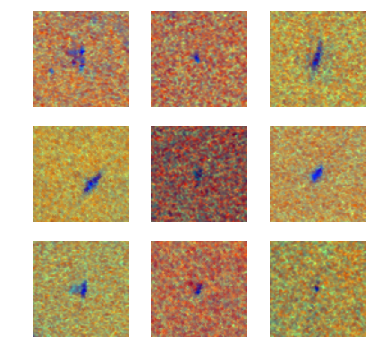

In [232]:
fig = plt.figure(figsize=(6,6))
for i in range(9):
    img = fig.add_subplot(3,3,i+1)
    img.imshow(trn_data[i])
    plt.axis('off')

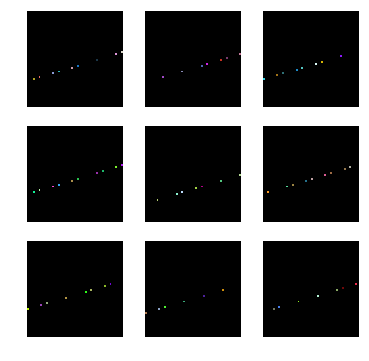

In [233]:
fig = plt.figure(figsize=(6,6))
for i in range(9):
    img = fig.add_subplot(3,3,i+1)
    img.imshow(augrs[i])
    plt.axis('off')

## Pretrained

In [73]:
trn_features = load_array(results_path+'trn_features.bc')
val_features = load_array(results_path+'val_features.bc')

In [76]:
# initial weights
b = np.zeros((2, 3), dtype='float32')
b[0, 0] = 1
b[1, 1] = 1
W = np.zeros((32, 6), dtype='float32')
weights = [W, b.flatten()]

In [77]:
def locnet():
    net = Sequential([
        #MaxPooling2D(input_shape=input_shape),
        Conv2D(32, (3,3), activation='relu', input_shape=trn_features[0].shape),
        MaxPooling2D(),
        #Conv2D(32, (3,3), activation='relu'),
        #MaxPooling2D(),
        
        Flatten(input_shape=input_shape),
        Dense(32, activation='relu'),
        Dense(6, activation='linear') #necessary because there are 6 affine transformations
    ])
    
    return net

In [78]:
vggloc = locnet()

In [80]:
vggloc.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_26 (Conv2D)           (None, 12, 12, 32)        147488    
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 6, 6, 32)          0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 1152)              0         
_________________________________________________________________
dense_15 (Dense)             (None, 32)                36896     
_________________________________________________________________
dense_16 (Dense)             (None, 6)                 198       
Total params: 184,582
Trainable params: 184,582
Non-trainable params: 0
_________________________________________________________________


In [106]:
def get_fcn():
    model = Sequential([
        SpatialTransformer(localization_net=vggloc, output_size=(12,12), input_shape=trn_features[0].shape),
        BatchNormalization(),
        MaxPooling2D(),
        ZeroPadding2D(),
        Convolution2D(16,(3,3), activation='relu'),
        BatchNormalization(),
        Dropout(0.1),
        Convolution2D(1, (3,3)),
        GlobalAveragePooling2D(),
        Activation('sigmoid')
    ])
    
    return model

In [107]:
model = get_fcn()

In [108]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
spatial_transformer_9 (Spati (None, 12, 12, 512)       184582    
_________________________________________________________________
batch_normalization_5 (Batch (None, 12, 12, 512)       2048      
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 6, 6, 512)         0         
_________________________________________________________________
zero_padding2d_3 (ZeroPaddin (None, 8, 8, 512)         0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 6, 6, 16)          73744     
_________________________________________________________________
batch_normalization_6 (Batch (None, 6, 6, 16)          64        
_________________________________________________________________
dropout_3 (Dropout)          (None, 6, 6, 16)          0         
__________

In [116]:
model.compile(optimizer=Adam(lr=1e-3), loss='binary_crossentropy', metrics=['accuracy'])

In [117]:
model.fit(trn_features, trn_labels, batch_size=batch_size, epochs=10, verbose=1, callbacks=[reduce_lr],
         validation_data=(val_features, val_labels))

Train on 200 samples, validate on 50 samples
Epoch 1/10
200/200 [==============================] - 8s 39ms/step - loss: 0.2909 - acc: 0.8650 - val_loss: 5.1232 - val_acc: 0.6600
Epoch 2/10
200/200 [==============================] - 7s 35ms/step - loss: 0.3047 - acc: 0.8600 - val_loss: 5.0583 - val_acc: 0.6600
Epoch 3/10
200/200 [==============================] - 7s 35ms/step - loss: 0.2640 - acc: 0.8800 - val_loss: 5.0127 - val_acc: 0.6600
Epoch 4/10
200/200 [==============================] - 7s 34ms/step - loss: 0.2771 - acc: 0.8800 - val_loss: 4.9568 - val_acc: 0.6600
Epoch 5/10
200/200 [==============================] - 7s 34ms/step - loss: 0.2609 - acc: 0.8700 - val_loss: 4.8754 - val_acc: 0.6600
Epoch 6/10


KeyboardInterrupt: 

In [113]:
vggloc_preds = vggloc.predict(trn_features, batch_size=batch_size, verbose=1)

200/200 [==============================] - 1s 5ms/step


In [114]:
vggloc_preds[0]

array([-603796.9375  ,  622791.6875  ,  629652.625   ,  551109.5625  ,
        232985.015625, -296426.53125 ], dtype=float32)

In [115]:
[o/np.sqrt(max(vggloc_preds[0]**2)) for o in vggloc_preds[0]]

[-0.95893657, 0.98910362, 1.0, 0.8752597, 0.37002152, -0.4707779]